In [1]:
import os

In [2]:
#os.listdir()

['.ipynb_checkpoints',
 'df_text.csv',
 'Dossier_Images_P6_NLP',
 'matrice_confusion_VGG16.png',
 'model1_best_weights.h5',
 'model2_best_weights.h5',
 'modele_2_supervise_convolution.png',
 'modele_2_supervise_matrice_confusion.png',
 'modele_supervise_avec_datageneration.png',
 'modele_supervise_matrice_confusion.png',
 'P6_Avis_restaurants(def).ipynb',
 'P6_Avis_restaurants(def_copie).ipynb',
 'P6_Avis_restaurants(def_image).ipynb',
 'P6_Avis_restaurants(def_text).ipynb',
 'restaurants.csv',
 'standard.png',
 'Untitled.ipynb',
 'visualisation_classe_maj_KmeansVGG16_vraies_classes.png',
 'visualisation_classe_maj_Kmeans_VGG16.png',
 'Visualisation_clusters_par_classe_majoritaire_Kmeans_VGG16.png',
 'visualisation_tsne_sift_vraies_classes.png',
 'visualisation_tsne_VGG16_clusters.png',
 'visualisation_tsne_VGG16_vraies_classes.png']

In [3]:
import logging
logging.root.handlers = []  # Jupyter messes up logging so needs a reset
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from smart_open import smart_open

import pandas as pd
import numpy as np
from numpy import random

import seaborn as sns
import matplotlib.pyplot as plt

import re

#import gensim
#import nltk

import sklearn
from sklearn.model_selection import train_test_split

from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
#from gensim.models import Word2Vec
#from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
#from nltk.corpus import stopwords



2023-12-11 12:21:49,111 : INFO : Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2023-12-11 12:21:49,112 : INFO : NumExpr defaulting to 8 threads.


In [4]:
sns.set()

In [5]:
!pip install voila
!jupyter nbextension enable --py widgetsnbextension --sys-prefix
!jupyter nbextension enable --py voila --sys-prefix
!jupyter serverextension enable --py voila --sys-prefix

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: console dejavu events execute kernel kernelspec lab
labextension labhub migrate nbclassic nbconvert notebook qtconsole run script
server troubleshoot trust

Jupyter command `jupyter-nbextension` not found.
usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runti

# *Analyse de texte et d'images*



Problématique : L'entreprise Avis restausouhaite améliorer sa plateforme avec une nouvelle fonctionnalité de collaboration. Les utilisateurs pourront par exemple poster des avis et des photos sur leur restaurant préféré. Ce sera aussi l’occasion, pour l’entreprise, de mieux comprendre les avis postés par les utilisateurs.

Méthodologie : Il est est demandé de proposer un outil qui permette de faire une analyse de feasabilité à partir des textes postés en tant qu'avis des utilisateurs a fin de comprendre, le cas échéant, des évetuelles raisons d'insatisfaction. Une analyse des images postés par les utilisateurs et un travail de récuperation de nouvelles données sur les restaurant afin de vérifier que l'outil est assez robuste pour l'envoyer en production.

Méthodologie technique :

2. Analyse des images postés par les clients
> - Préparation des données (Création des features)
> - Analyse par une méthode non-supérvisée (ACP, clustering, T-SNE, Kmeans)
> - SIFT
> - Modèle VGG16 (Transfer learning)
> - Approche ImageDatagenerator avec data augmentation
> - Approche sans data augmentation
> - Approche avec data augmentation intégrée au modèle

3. Récupération des données et création d'un fichier csv pour faciliter leur utilisation


# 2. Analyse des images (à partir des images postées par les clients)

In [6]:
! pip install pillow

In [7]:
# Importer les librairies nécessaires
import numpy as np
import matplotlib.pyplot as plt
import os
import PIL
import PIL.Image
import PIL.ImageStat

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers


In [8]:
! dir 

#! pip install google-auth google-auth-oauthlib google-auth-httplib2

 Le volume dans le lecteur C s’appelle Windows
 Le numéro de série du volume est F6CA-6D9F

 Répertoire de C:\Users\andre\OC Projets\P6 - NLP

11/12/2023  12:21    <DIR>          .
05/12/2023  17:17    <DIR>          ..
11/12/2023  11:53    <DIR>          .ipynb_checkpoints
04/12/2023  10:53        72 003 677 df_text.csv
07/12/2023  04:03    <DIR>          Dossier_Images_P6_NLP
11/12/2023  12:17            24 417 matrice_confusion_VGG16.png
11/12/2023  12:20        60 007 856 model1_best_weights.h5
09/12/2023  14:19        60 007 888 model2_best_weights.h5
09/12/2023  07:45             2 487 modele_2_supervise_convolution.png
09/12/2023  14:12            16 367 modele_2_supervise_matrice_confusion.png
09/12/2023  14:14             2 487 modele_supervise_avec_datageneration.png
09/12/2023  14:13            16 367 modele_supervise_matrice_confusion.png
08/12/2023  15:14        11 793 855 P6_Avis_restaurants(def).ipynb
11/12/2023  11:04        17 067 709 P6_Avis_restaurants(def_copie).ipy

In [9]:
! pip install pathlib
import pathlib

In [10]:
import os
# récupérer le chemin du répertoire courant
path = os.getcwd()
print("Le répertoire courant est : " + path)
# récupérer le nom du répertoire courant
repn = os.path.basename(path)
print("Le nom du répertoire est : " + repn)

Le répertoire courant est : C:\Users\andre\OC Projets\P6 - NLP
Le nom du répertoire est : P6 - NLP


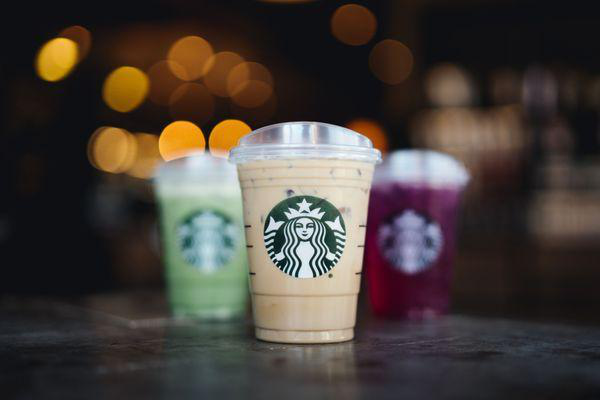

In [11]:
import PIL
from PIL import Image

img = Image.open(r"C:\Users\andre\OC Projets\P6 - NLP\Dossier_Images_P6_NLP\dfdrink\706nCeG3Ryud_nT5raiJeA.jpg")
img

Processing images in .ipynb_checkpoints
Processing images in dfdrink
Processing images in dffood
Processing images in dfinside
Processing images in dfmenu
Processing images in dfoutside


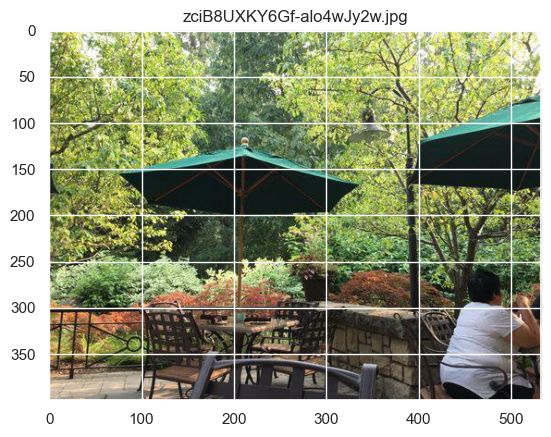

In [12]:
from PIL import Image
import matplotlib.pyplot as plt
import pathlib

# Define the path to the parent directory containing subdirectories with images
dataset_orig = (r"C:\Users\andre\OC Projets\P6 - NLP\Dossier_Images_P6_NLP")
data_dir = pathlib.Path(dataset_orig)

# Get a list of subdirectories
subdirectories = [subdir for subdir in data_dir.iterdir() if subdir.is_dir()]

# Display images from each subdirectory
for subdir in subdirectories:
    print(f"Processing images in {subdir.name}")
    
    # Get a list of image files in the subdirectory
    image_files = list(subdir.glob("*.jpg")) + list(subdir.glob("*.png"))  # Adjust file extensions as needed
    
    # Display each image in the subdirectory
    for image_file in image_files:
        # Open the image using PIL
        image = Image.open(image_file)

        # Display the image using Matplotlib
        plt.imshow(image)
        plt.title(image_file.name)  # Display the file name as the title


#### Comptage des images disponibles

In [13]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

250


#### Vérification de la lecture des images

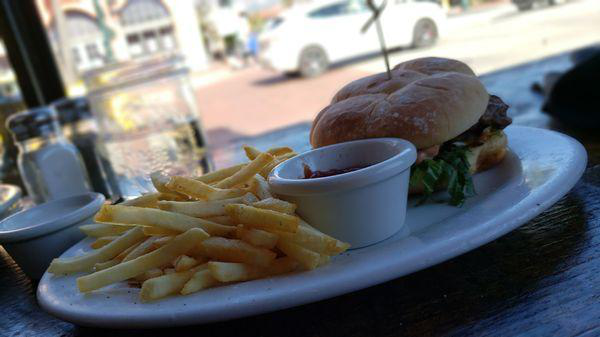

In [14]:
dffood = list(data_dir.glob('dffood/*'))# la fonction glob() est utilisée pour trouver tous les fichiers dans le répertoire data_dir qui correspondent au modèle *.
PIL.Image.open(str(dffood[0]))

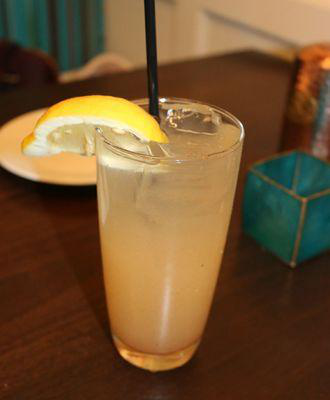

In [15]:
dfdrink = list(data_dir.glob('dfdrink/*'))
PIL.Image.open(str(dfdrink[22]))

## Chargement des images utilisant tf.keras.utils.image_dataset_from_directory

## Accès aux données depuis l'arborescence et création d'un df "data"

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [17]:
import os
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from glob import glob

path = r"C:\Users\andre\OC Projets\P6 - NLP\Dossier_Images_P6_NLP"

list_labels = ["dfdrink", "dffood", "dfinside", "dfmenu", "dfoutside"]
label_no_name = "no_name "

def photo_class(photo):
    for label in list_labels:
        if label in photo[24:]:
            return label
    return label_no_name

data_path = glob(os.path.join(path, '*', '*.jpg'))

def data_fct(path):
    list_photos = [file for file in path]
    print(len(list_photos))
    data = pd.DataFrame()
    data["image_path"] = list_photos
    data["label_name"] = data["image_path"].apply(lambda x: photo_class(x))
    return data

data = data_fct(data_path)

le = preprocessing.LabelEncoder()
le.fit(data["label_name"])
data["label"] = le.transform(data["label_name"])

data.tail(5)


250


image_path label_name  label
245  C:\Users\andre\OC Projets\P6 - NLP\Dossier_Ima...  dfoutside      4
246  C:\Users\andre\OC Projets\P6 - NLP\Dossier_Ima...  dfoutside      4
247  C:\Users\andre\OC Projets\P6 - NLP\Dossier_Ima...  dfoutside      4
248  C:\Users\andre\OC Projets\P6 - NLP\Dossier_Ima...  dfoutside      4
249  C:\Users\andre\OC Projets\P6 - NLP\Dossier_Ima...  dfoutside      4

#### Vérification de la composition du df "data"

In [18]:
data.groupby("label").count()

image_path  label_name
label                        
0              50          50
1              50          50
2              50          50
3              50          50
4              50          50

In [19]:
data.head()

image_path label_name  label
0  C:\Users\andre\OC Projets\P6 - NLP\Dossier_Ima...    dfdrink      0
1  C:\Users\andre\OC Projets\P6 - NLP\Dossier_Ima...    dfdrink      0
2  C:\Users\andre\OC Projets\P6 - NLP\Dossier_Ima...    dfdrink      0
3  C:\Users\andre\OC Projets\P6 - NLP\Dossier_Ima...    dfdrink      0
4  C:\Users\andre\OC Projets\P6 - NLP\Dossier_Ima...    dfdrink      0

#### Identification pour vérification du vecteur de classement

In [20]:
# Vérification par index (l, col) du classement des
data.iloc[224, 2]

4

In [21]:
# Vérification par index (l, col) du classement des
data.iloc[113, 2]

2

In [22]:
# Vérification par index (l, col) du classement des
data.iloc[0, 2]

0

In [23]:
# Vérification par index (l, col) du classement des
data.iloc[56, 2]

1

#### Affichage des quelques images pour vérification du bon chargement

dfdrink


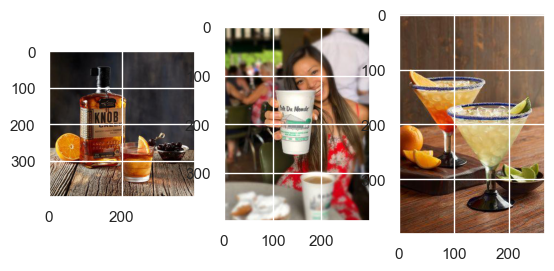

dffood


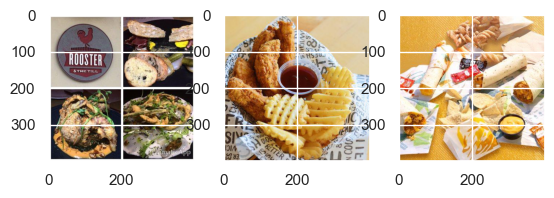

dfinside


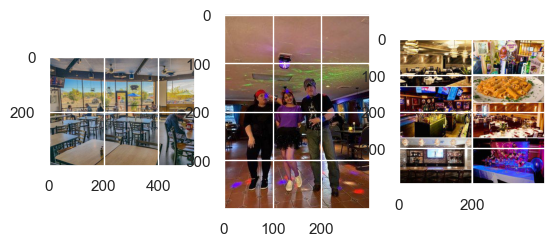

dfmenu


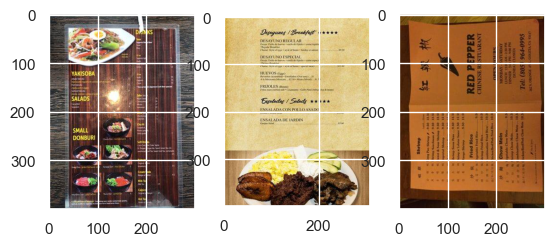

dfoutside


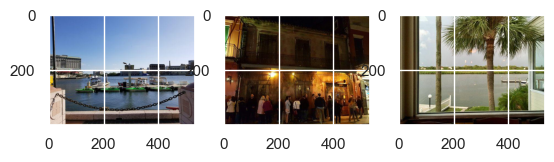

In [24]:
from matplotlib.image import imread

def list_fct(name) :
    list_image_name = [data["image_path"][i] for i in range(len(data)) if data["label_name"][i]==name]
    return list_image_name

list_drink=[data["image_path"][i] for i in range(len(data)) if data["label_name"][i]=="dfdrink"]
list_food=[data["image_path"][i] for i in range(len(data)) if data["label_name"][i]=="dffood"]
list_inside=[data["image_path"][i] for i in range(len(data)) if data["label_name"][i]=="dfinside"]
list_menu=[data["image_path"][i] for i in range(len(data)) if data["label_name"][i]=="dfmenu"]
list_outside=[data["image_path"][i] for i in range(len(data)) if data["label_name"][i]=="dfoutside"]

for name in list_labels :
    print(name)
    # print("-------")
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = list_fct(name)[i+10]
        image = imread(filename)
        plt.imshow(image)
    plt.show()

# Pré-traîtement des images

In [25]:
! pip install opencv-python

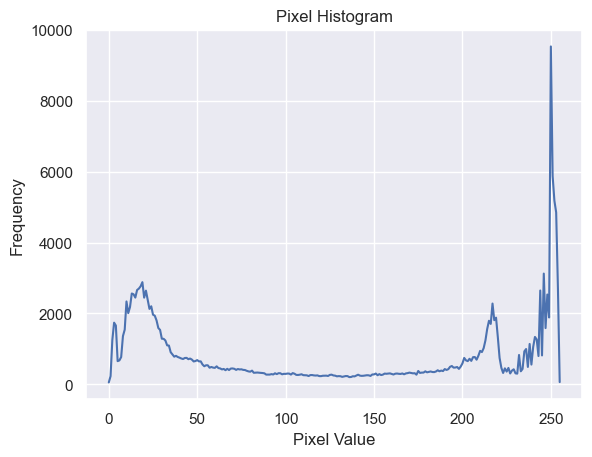

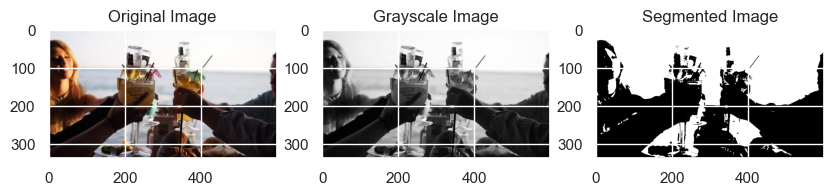

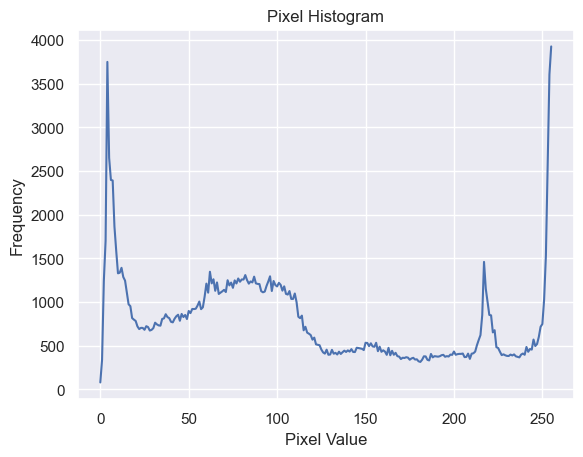

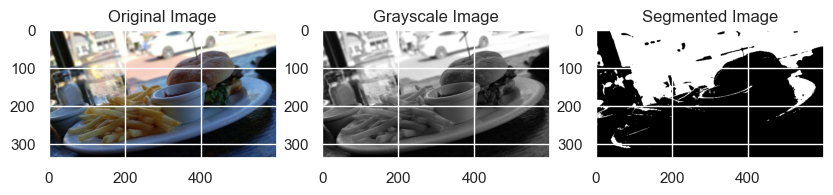

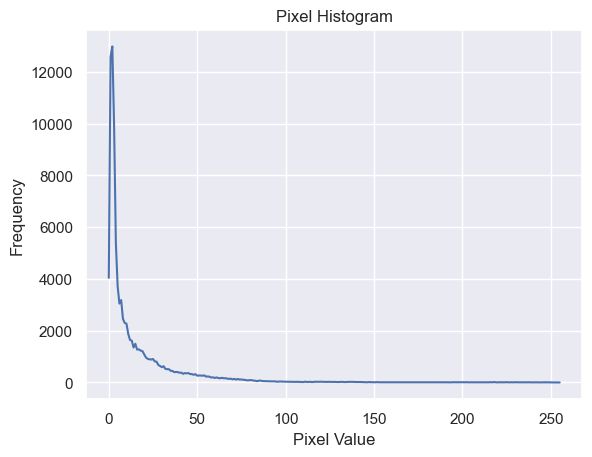

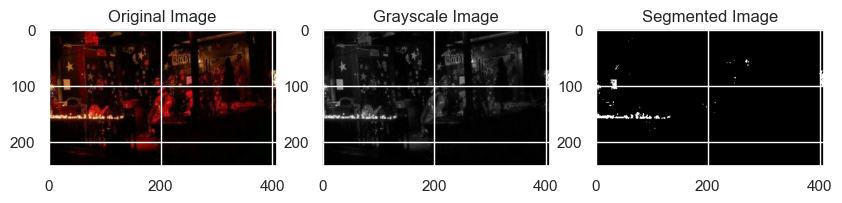

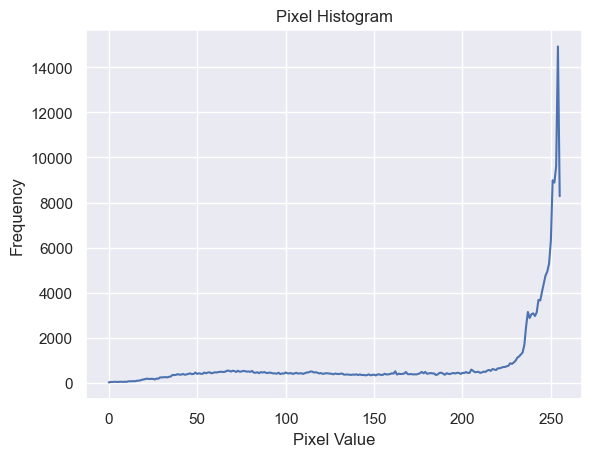

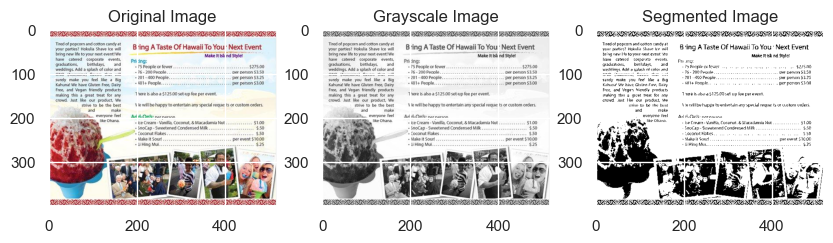

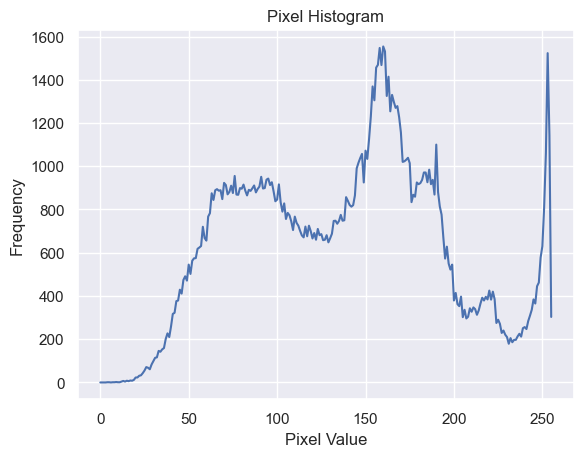

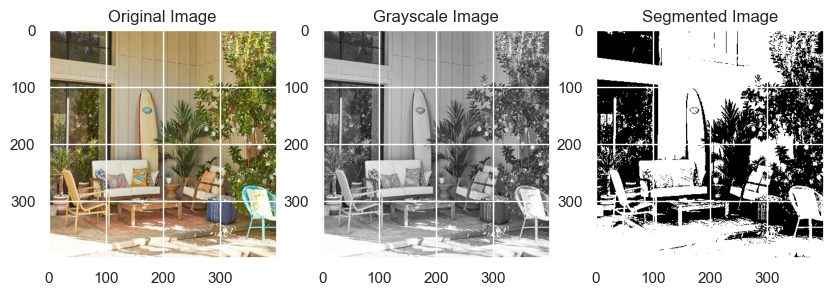

In [26]:
import cv2
import numpy as np

# Charger une image et effectuer le prétraitement
def preprocess_image(image_path):
    # Charger l'image
    original_image = cv2.imread(image_path)
    
    # Convertir en niveaux de gris
    gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    
    # Afficher l'histogramme de pixels
    hist = cv2.calcHist([gray_image], [0], None, [256], [0, 256])
    plt.plot(hist)
    plt.title("Pixel Histogram")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.show()
    
    # Appliquer une segmentation
    _, segmented_image = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY)
    
    return gray_image, segmented_image

# Echantillonner des images par classe
for label in list_labels:
    # Sélectionner une image de chaque classe
    sample_image_path = data[data["label_name"] == label]["image_path"].iloc[0]
    
    # Prétraiter l'image
    gray_image, segmented_image = preprocess_image(sample_image_path)
    
    # Afficher les images prétraitées
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(cv2.imread(sample_image_path), cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    
    plt.subplot(1, 3, 2)
    plt.imshow(gray_image, cmap='gray')
    plt.title("Grayscale Image")
    
    plt.subplot(1, 3, 3)
    plt.imshow(segmented_image, cmap='gray')
    plt.title("Segmented Image")
    
    plt.show()


#### SIFT

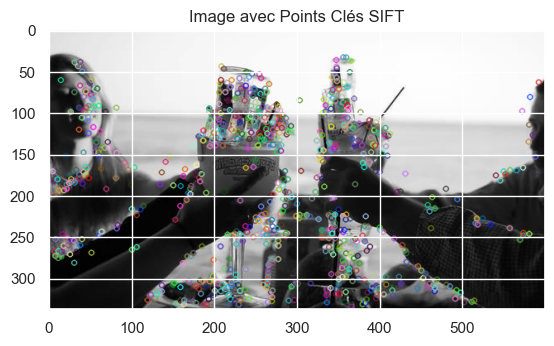

In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Charger une image à partir de votre DataFrame (par exemple, la première image)
image_path = data['image_path'].iloc[0]
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Initialiser l'objet SIFT
sift = cv2.SIFT_create()

# Trouver les points clés et les descripteurs avec SIFT
keypoints, descriptors = sift.detectAndCompute(image, None)

# Dessiner les points clés sur l'image
image_with_keypoints = cv2.drawKeypoints(image, keypoints, None)

# Afficher l'image avec les points clés à l'aide de Matplotlib
plt.imshow(image_with_keypoints, cmap='gray')
plt.title('Image avec Points Clés SIFT')
plt.show()



### Création des descripteurs 

In [28]:
import cv2
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Charger les images et calculer les descripteurs SIFT
descriptors_list = []
for image_path in data['image_path']:
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    keypoints, descriptors = sift.detectAndCompute(image, None)
    descriptors_list.append(descriptors)

# Concaténer tous les descripteurs pour former une seule matrice
all_descriptors = np.concatenate(descriptors_list, axis=0)
print(all_descriptors)

[[ 95.  23.   0. ...   0.   1.   2.]
 [  3.   0.   0. ...   0.   1.   7.]
 [132.  85.   0. ...   0.   0.   0.]
 ...
 [  9.  14.  25. ...   0.   0.   0.]
 [ 16.   0.   0. ...  81.  73.  24.]
 [ 11.  45.  76. ...   0.   0.   0.]]


In [29]:
import cv2
import numpy as np

# Charger une image à partir de votre DataFrame (par exemple, la première image)
image_path = data['image_path'].iloc[0]
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Trouver les points clés et les descripteurs avec SIFT
sift = cv2.SIFT_create()
keypoints, descriptors = sift.detectAndCompute(image, None)

# Afficher la forme des descripteurs
print("Forme des descripteurs SIFT:", descriptors.shape)


Forme des descripteurs SIFT: (783, 128)


### Visual words

### Réduction de dimension - ACP 

In [30]:
from sklearn import manifold, decomposition

print(descriptors.shape)
pca = decomposition.PCA(n_components=0.99)
femat_pca= pca.fit_transform(descriptors)
print(femat_pca.shape)

(783, 128)
(783, 104)


### Réduction de dimension T-SNE et affichage des images selon vraies classes

In [31]:
from sklearn import manifold, decomposition
import time

temps1 = time.time()

tsne_sift = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=42)
X_tsne_sift = tsne_sift.fit_transform(femat_pca)

duration1=time.time()-temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

temps de T-SNE :            19.24 secondes


### Visualisation du TSNE selon les vraies classes

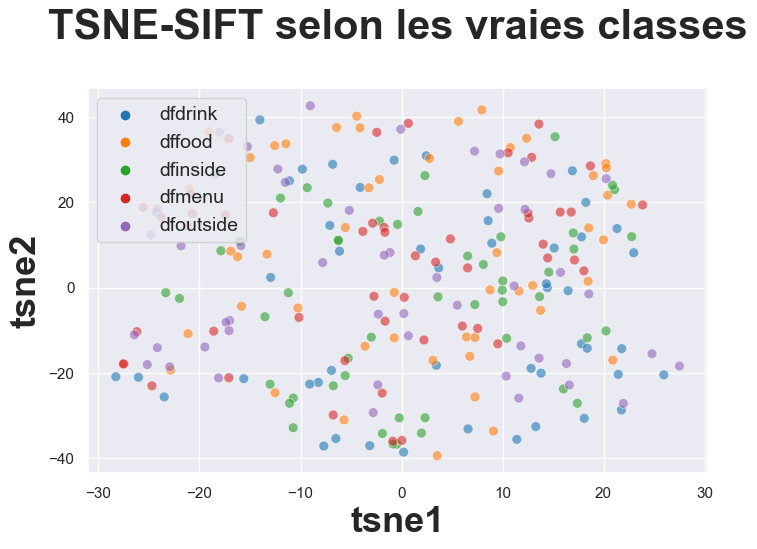

In [32]:
df_tsne_sift = pd.DataFrame(X_tsne_sift, columns=['tsne1', 'tsne2'])
df_tsne_sift["class"] = data["label_name"]

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors=5), s=50, alpha=0.6,
    data=df_tsne_sift,
    legend="brief")

plt.title('TSNE-SIFT selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14})

# Enregistrer le graphique en tant qu'image 
plt.savefig('visualisation_tsne_sift_vraies_classes.png', bbox_inches='tight')

# Afficher le graphique
plt.show()

* Nous observons ici qu'une séparation automatique des images selon les vraies classes avec la méthode SIFT ne semble pas être très efficace. 
* Ceci nous conduit à nous intérroger sur la feasabilité d'une classification efficace depuis cet angle.
* Nous utilisons le modèle pré-entrainé de VGG16 pour voir 

In [33]:
df_tsne_sift.head()

tsne1      tsne2    class
0  21.795839 -14.295252  dfdrink
1  16.911846  27.345747  dfdrink
2 -12.955087   2.380661  dfdrink
3 -24.268290  17.649143  dfdrink
4  17.815678 -13.154696  dfdrink

# Etude de faisabilité avec VGG16

#### Création d'un modèle pré-entraîné avec VGG16

In [34]:
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)#on enlève la tête pour pouvoir le réutiliser sur notre jeu des données

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Création des features des images

In [35]:
images_features = []
i=0
for image_file in data["image_path"] :
    if i%100 == 0 : print(i)
    i +=1
    image = load_img(image_file, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_features.append(model.predict(image)[0]) # predict from pretrained model

images_features = np.asarray(images_features)
images_features.shape

0
1/1 [==============================] - 0s 481ms/step
100
1/1 [==============================] - 0s 158ms/step
200
1/1 [==============================] - 0s 153ms/step


(250, 4096)

### Réduction dimension et analyse en composantes principales (ACP)

In [36]:
from sklearn import manifold, decomposition

print(images_features.shape)
pca = decomposition.PCA(n_components=0.99)#On retient 0.99% de variance
feat_pca= pca.fit_transform(images_features)
print(feat_pca.shape)

(250, 4096)
(250, 229)


### Réduction de dimension T-SNE et affichage des images selon vraies classes

In [37]:
from sklearn import manifold, decomposition
import time

temps1 = time.time()

tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=42)
X_tsne = tsne.fit_transform(feat_pca)

duration1=time.time()-temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

temps de T-SNE :             2.32 secondes


#### Visualisation du TSN selon les vraies classes

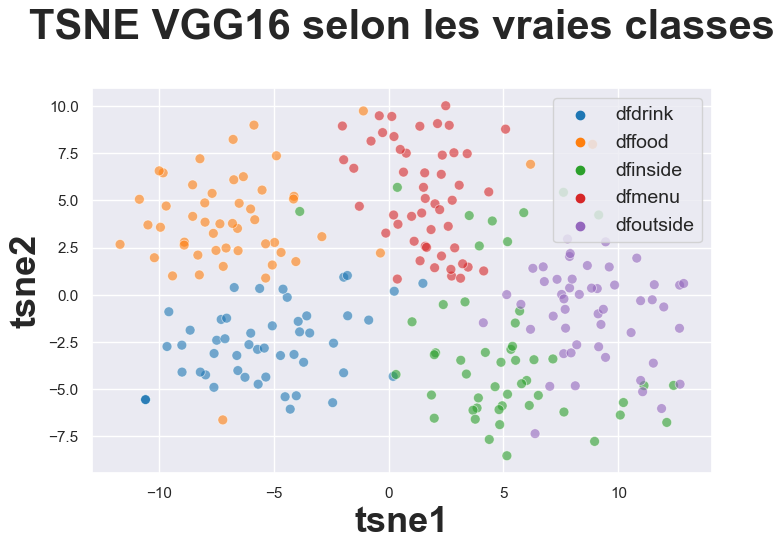

In [38]:
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["label_name"]

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors=5), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE VGG16 selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14})

# Enregistrer le graphique en tant qu'image 
plt.savefig('visualisation_tsne_VGG16_vraies_classes.png', bbox_inches='tight')

plt.show()

### Kmeans pour clustérisation

#### - Kmeans sur 5 clusters pour les 5 labels à trouver

In [39]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=5, n_init=100)
cls.fit(X_tsne)

C:\Users\andre\anaconda3\envs\P6_texte_image\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=5, n_init=100)

#### - Visualisation des résultats du Kmeans sur les 5 clusters

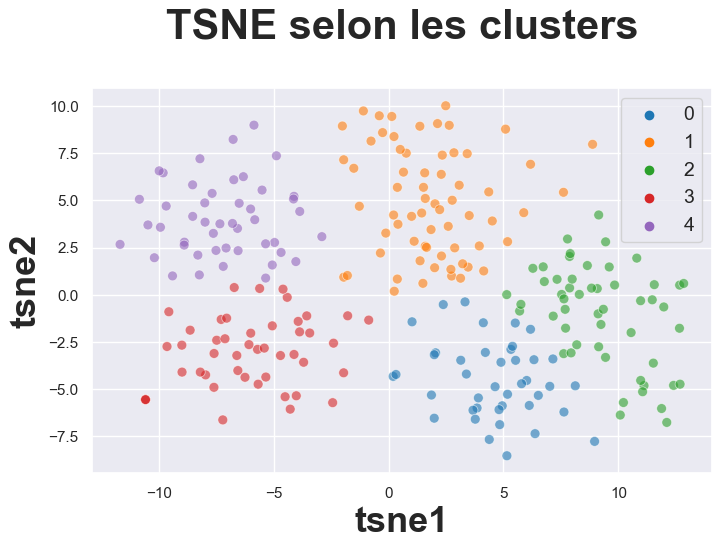

ARI :  0.7271462678440808


In [40]:
df_tsne["cluster"] = cls.labels_

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=5), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14})

# Enregistrer le graphique en tant qu'image 
plt.savefig('visualisation_tsne_VGG16_clusters.png', bbox_inches='tight')

plt.show()

labels = data["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

Notre score ARI est de 0.6824919895258987 cela implique que les clusters trouvés par le modèle K-means sont en moyenne de 68,24% similaires aux classes réelles des images. Cela signifie que le modèle a fait un bon travail de regroupement des images en fonction de leurs caractéristiques. Cependant, il est important de noter que l'ARI est une mesure de cohérence, pas de précision. Un score de ce type nous permet d'inférer que le modèle a regroupé des images de différentes classes dans le même cluster ou qu'il ait fait des erreurs de classification sur des images qui font pourtant partie de chaque classe réelle. Pour voir un peu à quoi ressemble le classement par cluster et s'il conincide ou non avec les labels réels, nous faissons un print du df_tsne, que maintenant inclut la colonne cluster.

In [41]:
df_tsne.head()

tsne1     tsne2    class  cluster
0 -2.397175 -2.565265  dfdrink        3
1 -4.116532 -3.163910  dfdrink        3
2 -3.433143 -2.027306  dfdrink        3
3  1.494267  0.605013  dfdrink        1
4 -7.287878 -1.308731  dfdrink        3

#### Accès simplifié aux classes majoritairement attribuée par cluster par le Kmeans

In [42]:
# Obtenir les étiquettes réelles des images de chaque cluster
labels_par_cluster = df_tsne.groupby("cluster")["class"].value_counts()

# Afficher les étiquettes réelles des images du cluster 0
print(labels_par_cluster[0])

class
dfinside     35
dfoutside     5
dfdrink       1
Name: count, dtype: int64


Nous inférons que la classe majoriatire est du cluster 0 est dfoutside

In [43]:
# Obtenir les étiquettes réelles des images de chaque cluster
labels_par_cluster = df_tsne.groupby("cluster")["class"].value_counts()

# Afficher les étiquettes réelles des images du cluster 1
print(labels_par_cluster[1])

class
dfmenu      50
dfinside     7
dfdrink      4
dffood       4
Name: count, dtype: int64


In [44]:
# Obtenir les étiquettes réelles des images de chaque cluster
labels_par_cluster = df_tsne.groupby("cluster")["class"].value_counts()

# Afficher les étiquettes réelles des images du cluster 2
print(labels_par_cluster[2])

class
dfoutside    45
dfinside      7
Name: count, dtype: int64


In [45]:
# Obtenir les étiquettes réelles des images de chaque cluster
labels_par_cluster = df_tsne.groupby("cluster")["class"].value_counts()

# Afficher les étiquettes réelles des images du cluster 3
print(labels_par_cluster[3])

class
dfdrink    45
dffood      1
Name: count, dtype: int64


#### Visualisation des clusters par classe majoritaire selon le Kmeans


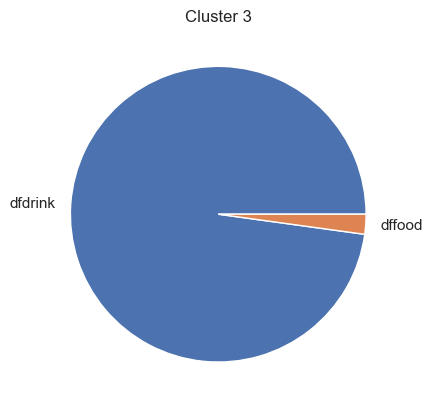

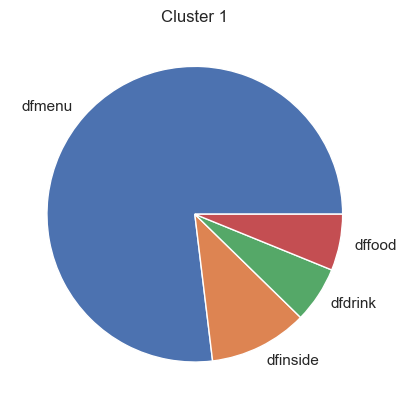

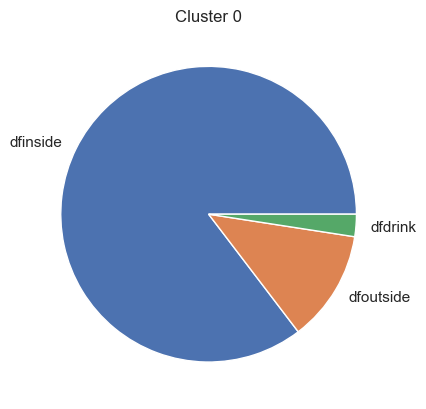

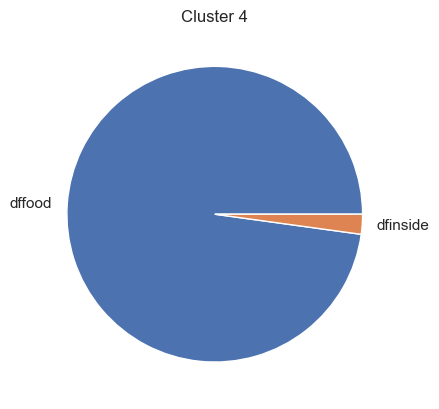

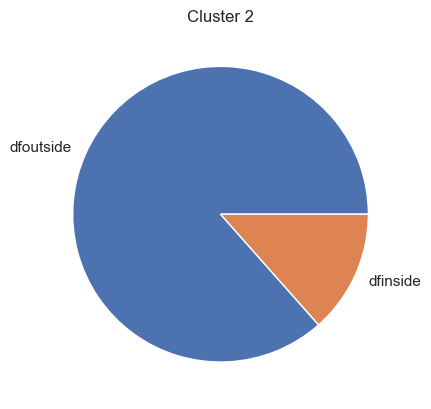

<Figure size 640x480 with 0 Axes>

In [46]:
for cluster in df_tsne["cluster"].unique():
    plt.pie(labels_par_cluster[cluster], labels=labels_par_cluster[cluster].index)
    plt.title(f"Cluster {cluster}")
    plt.show()

# Enregistrer le graphique en tant qu'image 
plt.savefig('visualisation_classe_maj_KmeansVGG16_vraies_classes.png', bbox_inches='tight')

#### Analyse des images "mal-classées"

1. Classement Tnse

In [47]:
df_tsne.head()

tsne1     tsne2    class  cluster
0 -2.397175 -2.565265  dfdrink        3
1 -4.116532 -3.163910  dfdrink        3
2 -3.433143 -2.027306  dfdrink        3
3  1.494267  0.605013  dfdrink        1
4 -7.287878 -1.308731  dfdrink        3

##### 2. Classement LE (classes réelles) 

In [48]:
data.head()

image_path label_name  label
0  C:\Users\andre\OC Projets\P6 - NLP\Dossier_Ima...    dfdrink      0
1  C:\Users\andre\OC Projets\P6 - NLP\Dossier_Ima...    dfdrink      0
2  C:\Users\andre\OC Projets\P6 - NLP\Dossier_Ima...    dfdrink      0
3  C:\Users\andre\OC Projets\P6 - NLP\Dossier_Ima...    dfdrink      0
4  C:\Users\andre\OC Projets\P6 - NLP\Dossier_Ima...    dfdrink      0

##### 3. Vérification humaine 

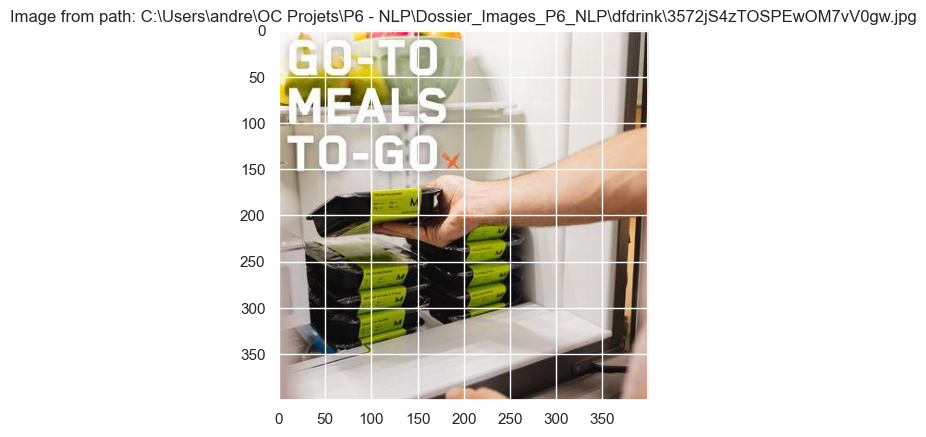

In [49]:
# Affichage de l'image classé  dans le cluster 4 = "dfdrink" dans le tsne mais qui en réalité fait partie d'un autre cluster (0 pour cet exemple)

image_path = data['image_path'].iloc[3]
image = plt.imread(image_path)

plt.imshow(image)
plt.title(f"Image from path: {image_path}")
plt.show()

### Analyse par classes

In [50]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[ 1  4  0 45  0]
 [ 0  4  0  1 45]
 [35  7  7  0  1]
 [ 0 50  0  0  0]
 [ 5  0 45  0  0]]


In [51]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)

    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x])

    return labels['y_pred_transform']

In [52]:
cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [2 3 4 0 1]
[[45  0  1  4  0]
 [ 1 45  0  4  0]
 [ 0  1 35  7  7]
 [ 0  0  0 50  0]
 [ 0  0  5  0 45]]

              precision    recall  f1-score   support

           0       0.98      0.90      0.94        50
           1       0.98      0.90      0.94        50
           2       0.85      0.70      0.77        50
           3       0.77      1.00      0.87        50
           4       0.87      0.90      0.88        50

    accuracy                           0.88       250
   macro avg       0.89      0.88      0.88       250
weighted avg       0.89      0.88      0.88       250



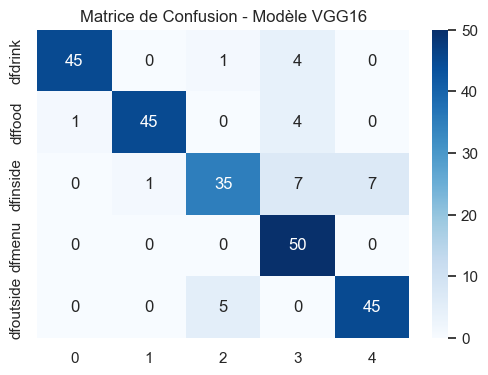

In [53]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "01234"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

# Ajouter un titre
plt.title('Matrice de Confusion - Modèle VGG16')

# Enregistrer le graphique en tant qu'image 
plt.savefig('matrice_confusion_VGG16.png', bbox_inches='tight')

# Afficher le graphique
plt.show()



Nous observons que malgré un excellent travail de la part du VGG16, nous procédons à une classification supervisée pour voir si l'on peut avor des meilleurs résultats. 

# Etape 2 : classification supervisée

## Création du modèle de classification

In [54]:
def create_model_fct() :
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(5, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())

    return model

## Approche préparation initiale des images

In [55]:
def image_prep_fct(data) :
    prepared_images = []
    for image_num in range(len(data['image_path'])) :
        img = (load_img(
            data['image_path'][image_num],
            target_size=(224, 224)))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)
    return prepared_images_np

images_np = image_prep_fct(data)
print(images_np.shape)

(250, 224, 224, 3)


In [56]:
X = images_np
y = to_categorical(data['label'])

y

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [57]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
X_train.shape

(187, 224, 224, 3)

In [58]:
X_val.shape

(63, 224, 224, 3)

In [59]:
# Création du modèle
with tf.device('/gpu:0'):
    model1 = create_model_fct()

# Création du callback
model1_save_path1 = "./model1_best_weights.h5"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
callbacks_list = [checkpoint, es]

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [60]:
# Entraîner sur les données d'entraînement (X_train, y_train)
with tf.device('/gpu:0'):
    history1 = model1.fit(X_train, y_train, epochs=50, batch_size=10,
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)

Epoch 1/50
19/19 [==============================] - ETA: 0s - loss: 5.8043 - accuracy: 0.4492
Epoch 1: val_loss improved from inf to 0.73968, saving model to .\model1_best_weights.h5
19/19 [==============================] - 28s 1s/step - loss: 5.8043 - accuracy: 0.4492 - val_loss: 0.7397 - val_accuracy: 0.8571
Epoch 2/50
19/19 [==============================] - ETA: 0s - loss: 1.7236 - accuracy: 0.7380
Epoch 2: val_loss did not improve from 0.73968
19/19 [==============================] - 26s 1s/step - loss: 1.7236 - accuracy: 0.7380 - val_loss: 0.9295 - val_accuracy: 0.8095
Epoch 3/50
19/19 [==============================] - ETA: 0s - loss: 0.7267 - accuracy: 0.8503
Epoch 3: val_loss did not improve from 0.73968
19/19 [==============================] - 25s 1s/step - loss: 0.7267 - accuracy: 0.8503 - val_loss: 0.8109 - val_accuracy: 0.8571
Epoch 4/50
19/19 [==============================] - ETA: 0s - loss: 0.6034 - accuracy: 0.8984
Epoch 4: val_loss did not improve from 0.73968
19/19 [

In [61]:
# Score du dernier epoch

loss, accuracy = model1.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

6/6 [==============================] - 18s 3s/step - loss: 0.0060 - accuracy: 0.9947
Training Accuracy: 0.9947

2/2 [==============================] - 6s 3s/step - loss: 0.9400 - accuracy: 0.7937
Validation Accuracy:  0.7937


In [62]:
# Score de l'epoch optimal

model1.load_weights(model1_save_path1)

loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

Validation Accuracy :  0.9048


In [63]:
!pip install plot_keras_history

<Figure size 640x480 with 0 Axes>

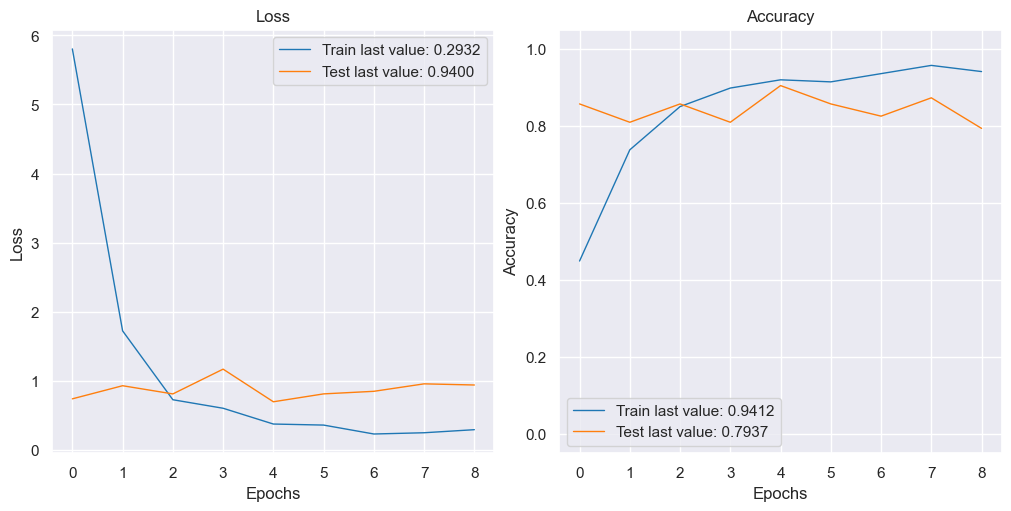

<Figure size 640x480 with 0 Axes>

In [64]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

# Ajouter un titre général
plt.suptitle("Modèle d'entraînement supervisé avec convolution", fontsize=32)

show_history(history1)
plot_history(history1, path="standard.png")

plt.close()

# Enregistrer le graphique en tant qu'image 
plt.savefig('modele_2_supervise_convolution.png', bbox_inches='tight')

In [65]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model1.predict(X_val), axis=1)
y_val_num = np.argmax(y_val, axis=1)
print(y_val_num)
print()
print(y_val_pred)

2/2 [==============================] - 7s 3s/step
[4 1 4 3 4 0 4 0 2 2 4 1 1 3 0 2 4 3 1 3 3 4 0 0 4 4 1 3 4 2 3 1 1 2 2 0 4
 3 0 0 2 2 1 3 1 0 0 4 0 1 2 1 1 4 2 3 2 0 3 2 1 3 2]

[2 1 4 3 4 1 4 0 2 2 4 1 1 3 0 2 4 3 1 3 3 4 2 0 4 4 1 3 4 2 3 1 1 2 2 0 4
 3 4 0 2 4 1 3 1 0 0 4 0 1 2 1 1 4 2 3 2 0 3 4 1 3 2]


In [66]:
from sklearn import metrics

conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

[[ 9  1  1  0  1]
 [ 0 13  0  0  0]
 [ 0  0 11  0  2]
 [ 0  0  0 12  0]
 [ 0  0  1  0 12]]


In [67]:
from sklearn import metrics

y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)
print(conf_mat)
print()
print(metrics.classification_report(y_val_num, y_val_pred_transform))

Correspondance des clusters :  [0 1 2 3 4]
[[ 9  1  1  0  1]
 [ 0 13  0  0  0]
 [ 0  0 11  0  2]
 [ 0  0  0 12  0]
 [ 0  0  1  0 12]]

              precision    recall  f1-score   support

           0       1.00      0.75      0.86        12
           1       0.93      1.00      0.96        13
           2       0.85      0.85      0.85        13
           3       1.00      1.00      1.00        12
           4       0.80      0.92      0.86        13

    accuracy                           0.90        63
   macro avg       0.91      0.90      0.90        63
weighted avg       0.91      0.90      0.90        63



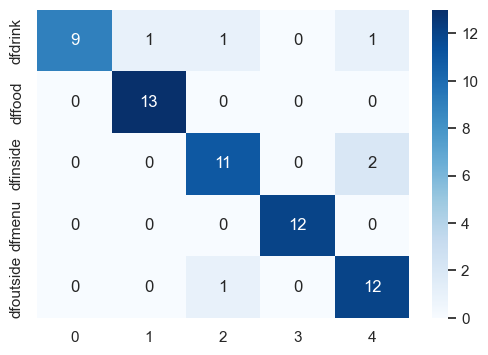

In [68]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "01234"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

# Enregistrer le graphique en tant qu'image 
plt.savefig('modele_supervise_matrice_confusion.png', bbox_inches='tight')

## Approche ImageDatagenerator avec data augmentation

In [69]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [70]:
# Pour mélanger les images, classées initalement par classe
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

In [71]:
batch_size = 10

def data_flow_fct(data, datagen, data_type=None) :
    data_flow = datagen.flow_from_dataframe(data, directory='',
                                x_col='image_path', y_col='label_name',
                                weight_col=None, target_size=(256, 256),
                                classes=None, class_mode='categorical',
                                batch_size=batch_size, shuffle=True, seed=42,
                                subset=data_type
                                )
    return data_flow

In [72]:
datagen_train = ImageDataGenerator(
#    featurewise_center=True,
#    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.20,
    preprocessing_function=preprocess_input)

train_flow = data_flow_fct(data, datagen_train, data_type='training')
val_flow = data_flow_fct(data, datagen_train, data_type='validation')

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
# datagen.fit(X_train)
# fits the model on batches with real-time data augmentation:

Found 200 validated image filenames belonging to 5 classes.
Found 50 validated image filenames belonging to 5 classes.


In [73]:
# Création du modèle
with tf.device('/gpu:0'):
    model2 = create_model_fct()

# Création du callback
model2_save_path = "./model2_best_weights.h5"
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [74]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [75]:
with tf.device('/gpu:0'):
    history2 = model2.fit(train_flow,
                    validation_data=val_flow,
                    batch_size=batch_size, epochs=20, callbacks=callbacks_list, verbose=1)


Epoch 1/20
20/20 [==============================] - ETA: 0s - loss: 4.5797 - accuracy: 0.4750
Epoch 1: val_loss improved from inf to 2.14622, saving model to .\model2_best_weights.h5
20/20 [==============================] - 41s 2s/step - loss: 4.5797 - accuracy: 0.4750 - val_loss: 2.1462 - val_accuracy: 0.7200
Epoch 2/20
20/20 [==============================] - ETA: 0s - loss: 1.8802 - accuracy: 0.7200
Epoch 2: val_loss improved from 2.14622 to 1.15003, saving model to .\model2_best_weights.h5
20/20 [==============================] - 38s 2s/step - loss: 1.8802 - accuracy: 0.7200 - val_loss: 1.1500 - val_accuracy: 0.7400
Epoch 3/20
20/20 [==============================] - ETA: 0s - loss: 1.1851 - accuracy: 0.7700
Epoch 3: val_loss did not improve from 1.15003
20/20 [==============================] - 39s 2s/step - loss: 1.1851 - accuracy: 0.7700 - val_loss: 1.3892 - val_accuracy: 0.7400
Epoch 4/20
20/20 [==============================] - ETA: 0s - loss: 0.7433 - accuracy: 0.8500
Epoch 4:

In [76]:
# Score du dernier epoch

loss, accuracy = model2.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model2.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

20/20 [==============================] - 28s 1s/step - loss: 0.0554 - accuracy: 0.9800
Training Accuracy   : 0.9800

5/5 [==============================] - 8s 1s/step - loss: 1.0787 - accuracy: 0.8400
Validation Accuracy :  0.8400


In [77]:
# Score de l'epoch optimal

model2.load_weights(model2_save_path)

loss, accuracy = model2.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

Validation Accuracy :  0.8400


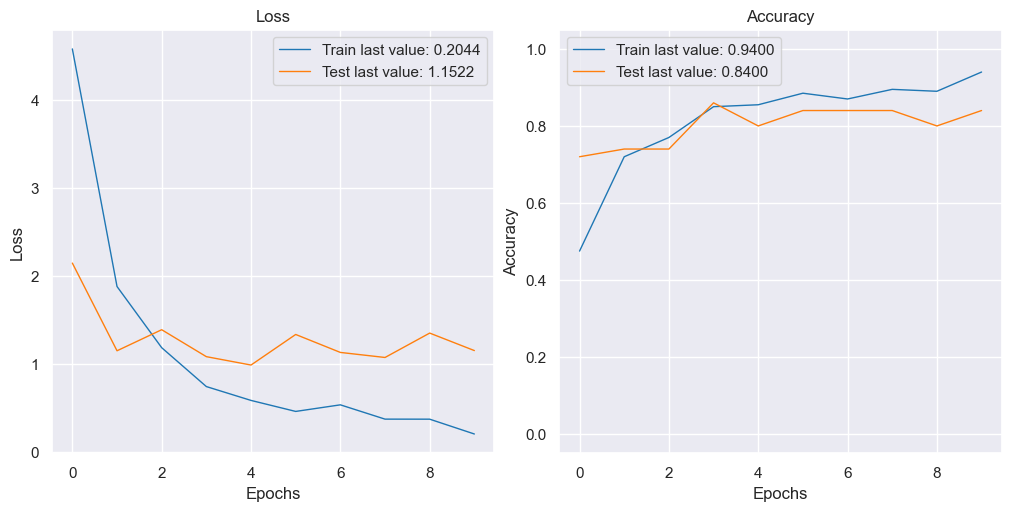

<Figure size 640x480 with 0 Axes>

In [78]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history2)
plot_history(history2, path="standard.png")
plt.close()

# Enregistrer le graphique en tant qu'image 
plt.savefig('modele_supervise_avec_datageneration.png', bbox_inches='tight')

# Récupération des données d'autres restaurants à partir de Yelp

In [79]:
! pip install requests

In [80]:
! pip install yelpapi

Approche 1. Restaurants à Paris

Dans cette récupération nous avons souhaité récupérer tous les restaurants disponibles sur yelp à Paris au moment de la requête.


In [81]:
import csv
from yelpapi import YelpAPI
import pprint

# clé API Yelp réelle
api_key = '-HctTi4HnHWi6NyIas9_zr32gtI1vttDRLRDEEGiczGG_AahVjgWsYRqKICbUJ8Ss_Jn4_GDcwm1wVDwOGN-HG0OCWHYPkJ7L4aU3WawpsSDTb1PUu9JXxVeBNRqZXYx'

# Fonction pour rechercher des restaurants à Paris avec pagination et sauvegarder dans un fichier CSV
def rechercher_restaurants(api_key, total_results=200, csv_filename='restaurants.csv'):
    with YelpAPI(api_key) as yelp_api:
        offset = 0
        limit = 50
        results = []

        while offset < total_results:
            # Recherche de restaurants à Paris avec pagination
            reponse = yelp_api.search_query(term='restaurants', location='Paris', limit=limit, offset=offset)

            # Ajouter les résultats actuels à la liste des résultats
            results.extend(reponse['businesses'])

            # Mettre à jour l'offset pour la prochaine itération
            offset += limit

        # Sauvegarder les résultats dans un fichier CSV
        with open(csv_filename, 'w', newline='', encoding='utf-8') as csvfile:
            fieldnames = ['id', 'name', 'rating', 'review_count', 'address']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

            # Écrire l'en-tête CSV
            writer.writeheader()

            # Écrire chaque ligne de données dans le fichier CSV
            for business in results:
                writer.writerow({
                    'id': business['id'],
                    'name': business['name'],
                    'rating': business['rating'],
                    'review_count': business['review_count'],
                    'address': ', '.join(business['location']['display_address'])
                })

# Appeler la fonction avec la clé API
rechercher_restaurants(api_key, total_results=200)


In [82]:
import pandas as pd

df_restaurants = pd.read_csv("restaurants.csv")
df_restaurants.head()


id                           name  rating  \
0  -0iLH7iQNYtoURciDpJf6w  Le Comptoir de la Gastronomie     4.5   
1  IU9_wVOGBKjfqTTpAXpKcQ           Bistro des Augustins     4.5   
2  cEjF41ZQB8-SST8cd3EsEw               L'Avant Comptoir     4.5   
3  BuJnfWI86tTxFUon071EKg            Brasserie Bellanger     5.0   
4  wLgAxIB7111BcWLWh7KpFw                    La Régalade     4.5   

   review_count                                            address  
0          1292             34 rue Montmartre, 75001 Paris, France  
1           483  39 quai des Grands Augustins, 75006 Paris, France  
2           656        3 carrefour de l'Odéon, 75006 Paris, France  
3            21  140 rue du Faubourg Poissonnière, 75010 Paris,...  
4           102          106 rue Saint-Honoré, 75001 Paris, France

In [83]:
df_restaurants.shape

(200, 5)